# How to train Boosted Trees models in TensorFlow
This tutorial is an end-to-end walkthrough of training a Gradient Boosting model using decision trees with the tf.estimator API. Boosted Trees models are among the most popular and effective machine learning approaches for both regression and classification. It is an ensemble technique that combines the predictions from several (think 10s, 100s or even 1000s) tree models.

Boosted Trees models are popular with many machine learning practioners as they can achieve impressive performance with minimal hyperparameter tuning.

In [3]:
# Setup.
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import tensorflow as tf

import os
import sys

import matplotlib.pyplot as plt
from IPython.display import clear_output

tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

## Dataset
The dataset consists of a training set and an evaluation set:

dftrain and y_train are the training set—the data the model uses to learn.
The model is tested against the eval set, dfeval, and y_eval.
For training you will use the following features:

Feature Name: Description

sex: Gender of passenger

age: Age of passenger

n_siblings_spouses: # siblings and partners aboard

parch: # of parents and children aboard

fare: Fare passenger paid.

class: Passenger's class on ship

deck: Which deck passenger was on

embark_town: Which town passenger embarked from

alone: If passenger was alone

In [4]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [5]:
# Explore the data.
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

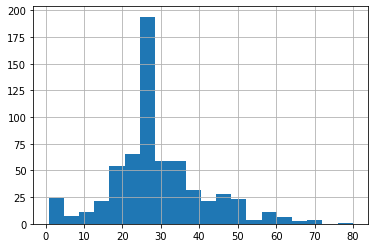

In [8]:
# The majority of passengers are in their 20's and 30's.
dftrain.age.hist(bins=20)

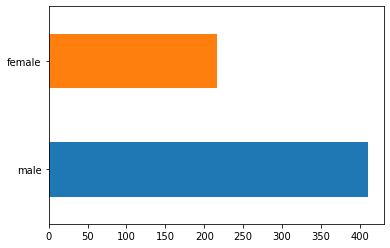

In [9]:
# There are approximately twice as male passengers as female passengers aboard.
dftrain.sex.value_counts().plot(kind='barh');

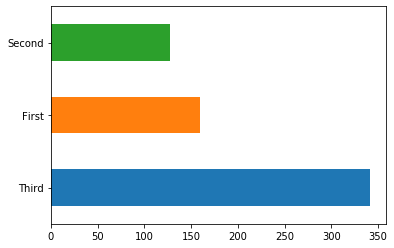

In [10]:
# The majority of passengers were in the "third" class.
(dftrain['class']
  .value_counts()
  .plot(kind='barh'));

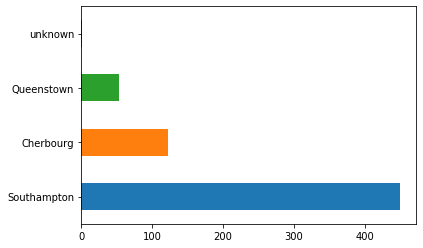

In [11]:
# Most passengers embarked from Southampton.
(dftrain['embark_town']
  .value_counts()
  .plot(kind='barh'));

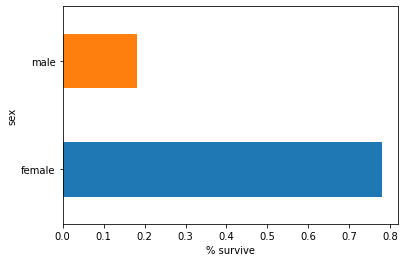

In [12]:
# Females have a much higher chance of surviving vs. males. 
# This will clearly be a predictive feature for the model.
ax = (pd.concat([dftrain, y_train], axis=1)\
  .groupby('sex')
  .survived
  .mean()
  .plot(kind='barh'))
ax.set_xlabel('% survive');

## Create feature columns and input functions
The Gradient Boosting estimator can utilize both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization. In this tutorial, the fields in CATEGORICAL_COLUMNS are transformed from categorical columns to one-hot-encoded columns (indicator column):

In [13]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [14]:
# You can view the transformation that a feature column produces.
example = dftrain.head(1)
class_fc = one_hot_cat_column('class', ('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]))

Feature value: "Third"
One-hot encoded:  tf.Tensor([[0. 0. 1.]], shape=(1, 3), dtype=float32)


In [15]:
# You can view all of the feature column transformations together:
fc.input_layer(dict(example), feature_columns)

<tf.Tensor: id=328, shape=(1, 34), dtype=float32, numpy=
array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)>

### Input functions.
Next you need to create the input functions. These will specify how data will be read into our model for both training and inference. You will use the from_tensor_slices method in the tf.data API to read in data directly from Pandas. This is suitable for smaller, in-memory datasets. For larger datasets, the tf.data API supports a variety of file formats (including csv) so that you can process datasets that do not fit in memory.

In [16]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)  
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## Train and evaluate the model
Below you will do the following steps:

1 - Initialize the model, 

2 - specifying the features and hyperparameters.

3 - Feed the training data to the model using the train_input_fn and train the model using the train function.

You will assess model performance using the evaluation set—in this example, the dfeval DataFrame. You will verify that the predictions match the labels from the y_eval array.
Before training a Boosted Trees model, let's first train a linear classifier (logistic regression model). It is best practice to start with simpler model to establish a benchmark.

In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


Next let's train a Boosted Trees model. For boosted trees, regression (BoostedTreesRegressor) and classification (BoostedTreesClassifier) are supported, along with using any twice differentiable custom loss (BoostedTreesEstimator). Since the goal is to predict a class - survive or not survive, you will use the BoostedTreesClassifier.

In [19]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.82575756
Dummy model:  0.625


For performance reasons, when your data fits in memory, it is recommended to use the boosted_trees_classifier_train_in_memory function. However if training time is not of a concern or if you have a very large dataset and want to do distributed training, use the tf.estimator.BoostedTrees API shown above.

When using this method, you should not batch your input data, as the method operates on the entire dataset.

In [21]:
def make_inmemory_train_input_fn(X, y):
  def input_fn():
    return dict(X), y
  return input_fn


train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
est = tf.contrib.estimator.boosted_trees_classifier_train_in_memory(
    train_input_fn,
    feature_columns)
print(est.evaluate(eval_input_fn)['accuracy'])

FailedPreconditionError: Attempting to use uninitialized value boosted_trees/are_features_cached
	 [[node boosted_trees/are_features_cached/read (defined at /Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/boosted_trees.py:158) ]]

Caused by op 'boosted_trees/are_features_cached/read', defined at:
  File "/Users/gmontes/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/gmontes/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/gmontes/anaconda3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Users/gmontes/anaconda3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Users/gmontes/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-bd45202ece2b>", line 11, in <module>
    feature_columns)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/contrib/estimator/python/estimator/boosted_trees.py", line 303, in boosted_trees_classifier_train_in_memory
    hooks=train_hooks)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 358, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1124, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1154, in _train_model_default
    features, labels, model_fn_lib.ModeKeys.TRAIN, self.config)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1112, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/contrib/estimator/python/estimator/boosted_trees.py", line 289, in _model_fn
    train_in_memory=True)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/boosted_trees.py", line 982, in _bt_model_fn
    are_boundaries_ready)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/boosted_trees.py", line 329, in _cache_transformed_features
    are_features_cached = _local_variable(False, name='are_features_cached')
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/boosted_trees.py", line 158, in _local_variable
    name=name)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3890, in identity
    "Identity", input=input, name=name)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value boosted_trees/are_features_cached
	 [[node boosted_trees/are_features_cached/read (defined at /Users/gmontes/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/boosted_trees.py:158) ]]


Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier, the eval_input_fn is defined using the entire evaluation set.

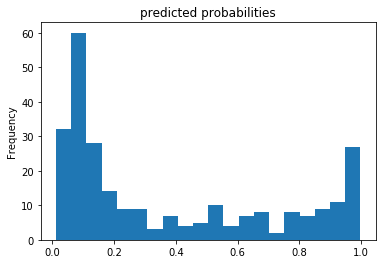

In [22]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

In [24]:
print(pred_dicts)

[{'logits': array([-2.1398106], dtype=float32), 'logistic': array([0.10528725], dtype=float32), 'probabilities': array([0.8947128 , 0.10528723], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object)}, {'logits': array([-2.125186], dtype=float32), 'logistic': array([0.10667288], dtype=float32), 'probabilities': array([0.8933271 , 0.10667287], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object)}, {'logits': array([-0.11013231], dtype=float32), 'logistic': array([0.47249472], dtype=float32), 'probabilities': array([0.5275053 , 0.47249472], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object)}, {'logits': array([-0.46146193], dtype=float32), 'logistic': array([0.3866391], dtype=float32), 'probabilities': array([0.61336094, 0.3866391 ], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object)}, {'logits': array([-2.0917273], dtype=float32), 'logistic': array([0.10990348], dtype=float32), 

Finally you can also look at the receiver operating characteristic (ROC) of the results, which will give us a better idea of the tradeoff between the true positive rate and false positive rate.

